In [229]:
import os
from collections import Counter
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor, ImageFont

In [2]:
input_dir = 'train_images/'

In [3]:
data_df = pd.read_csv('train.csv')
data_df

In [6]:
data_df.video_id.unique()

array([0, 1, 2])

In [7]:
data_df.sequence.unique().tolist()

[40258,
 45518,
 59337,
 8399,
 45015,
 35305,
 53708,
 996,
 60510,
 44160,
 15827,
 29424,
 8503,
 18048,
 17665,
 60754,
 37114,
 26651,
 22643,
 29859]

In [8]:
split_ratio = 0.8
split_index = int(split_ratio * len(data_df))
if data_df.iloc[split_index - 1].sequence == data_df.iloc[split_index].sequence:
    seq = data_df.iloc[split_index].sequence
    split_index = data_df.loc[data_df['sequence'] == seq].index[-1] + 1
split_index

19265

In [9]:
train_data_df = data_df[:split_index].sample(frac = 1).reset_index(drop=True)
test_data_df = data_df[split_index:].sample(frac = 1).reset_index(drop=True)
train_data_df

video_id  sequence  video_frame  sequence_frame image_id  \
0             0      8399         4156             418   0-4156   
1             1     60754         9265             849   1-9265   
2             0      8399         4981            1243   0-4981   
3             1     60510          909             909    1-909   
4             1     60754         8955             539   1-8955   
...         ...       ...          ...             ...      ...   
19260         1      8503         4081             253   1-4081   
19261         0     59337         2034             183   0-2034   
19262         1      8503         5471            1643   1-5471   
19263         2     26651         3786             114   2-3786   
19264         2     37114          665             665    2-665   

                                             annotations  
0                                                     []  
1      [{'x': 332, 'y': 239, 'width': 38, 'height': 2...  
2                                                     []  
3                                                     []  
4                                                     []  
...                                                  ...  
19260  [{'x': 0, 'y': 514, 'width': 36, 'height': 32}...  
19261                                                 []  
19262  [{'x': 392, 'y': 128, 'width': 55, 'height': 4...  
19263                                                 []  
19264                                                 []  

[19265 rows x 6 columns]

In [10]:
train_positive_num = len(train_data_df[train_data_df.annotations != '[]'])
test_positive_num = len(test_data_df[test_data_df.annotations != '[]'])
print('Training ratio (all samples):', 
      float(len(train_data_df)) / (len(train_data_df) + len(test_data_df)))
print('Training ratio (positive samples):', 
      float(train_positive_num) / (train_positive_num + test_positive_num))

Training ratio (all samples): 0.8197523509637887
Training ratio (positive samples): 0.868265907704818


In [11]:
train_data_df = train_data_df[train_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for training:', len(train_data_df))
test_data_df = test_data_df[test_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for testing:', len(test_data_df))
train_data_df

Number of positive images used for training: 4271
Number of positive images used for testing: 648


index  video_id  sequence  video_frame  sequence_frame image_id  \
0         1         1     60754         9265             849   1-9265   
1         9         1      8503         4776             948   1-4776   
2        11         1     60754         9067             651   1-9067   
3        13         1      8503         4247             419   1-4247   
4        18         0     53708         8940              55   0-8940   
...     ...       ...       ...          ...             ...      ...   
4266  19254         0      8399         4591             853   0-4591   
4267  19256         0      8399         4862            1124   0-4862   
4268  19257         1     15827         1996              78   1-1996   
4269  19260         1      8503         4081             253   1-4081   
4270  19262         1      8503         5471            1643   1-5471   

                                            annotations  
0     [{'x': 332, 'y': 239, 'width': 38, 'height': 2...  
1       [{'x': 0, 'y': 204, 'width': 33, 'height': 49}]  
2     [{'x': 446, 'y': 481, 'width': 65, 'height': 5...  
3     [{'x': 314, 'y': 431, 'width': 38, 'height': 3...  
4     [{'x': 971, 'y': 348, 'width': 36, 'height': 3...  
...                                                 ...  
4266  [{'x': 94, 'y': 138, 'width': 56, 'height': 53...  
4267  [{'x': 346, 'y': 360, 'width': 74, 'height': 48}]  
4268  [{'x': 922, 'y': 117, 'width': 44, 'height': 51}]  
4269  [{'x': 0, 'y': 514, 'width': 36, 'height': 32}...  
4270  [{'x': 392, 'y': 128, 'width': 55, 'height': 4...  

[4271 rows x 7 columns]

In [12]:
train_data_df["annotations"] = train_data_df["annotations"].map(lambda x: eval(x))
test_data_df["annotations"] = test_data_df["annotations"].map(lambda x : eval(x))
train_data_df["filepath"] = train_data_df.apply(lambda x : f"train_images/video_{x.video_id}/{x.video_frame}.jpg", axis=1)
test_data_df["filepath"] = test_data_df.apply(lambda x : f"train_images/video_{x.video_id}/{x.video_frame}.jpg", axis=1)
train_data_df

index  video_id  sequence  video_frame  sequence_frame image_id  \
0         1         1     60754         9265             849   1-9265   
1         9         1      8503         4776             948   1-4776   
2        11         1     60754         9067             651   1-9067   
3        13         1      8503         4247             419   1-4247   
4        18         0     53708         8940              55   0-8940   
...     ...       ...       ...          ...             ...      ...   
4266  19254         0      8399         4591             853   0-4591   
4267  19256         0      8399         4862            1124   0-4862   
4268  19257         1     15827         1996              78   1-1996   
4269  19260         1      8503         4081             253   1-4081   
4270  19262         1      8503         5471            1643   1-5471   

                                            annotations          filepath  
0     [{'x': 332, 'y': 239, 'width': 38, 'height': 2...  video_1/9265.jpg  
1       [{'x': 0, 'y': 204, 'width': 33, 'height': 49}]  video_1/4776.jpg  
2     [{'x': 446, 'y': 481, 'width': 65, 'height': 5...  video_1/9067.jpg  
3     [{'x': 314, 'y': 431, 'width': 38, 'height': 3...  video_1/4247.jpg  
4     [{'x': 971, 'y': 348, 'width': 36, 'height': 3...  video_0/8940.jpg  
...                                                 ...               ...  
4266  [{'x': 94, 'y': 138, 'width': 56, 'height': 53...  video_0/4591.jpg  
4267  [{'x': 346, 'y': 360, 'width': 74, 'height': 48}]  video_0/4862.jpg  
4268  [{'x': 922, 'y': 117, 'width': 44, 'height': 51}]  video_1/1996.jpg  
4269  [{'x': 0, 'y': 514, 'width': 36, 'height': 32}...  video_1/4081.jpg  
4270  [{'x': 392, 'y': 128, 'width': 55, 'height': 4...  video_1/5471.jpg  

[4271 rows x 8 columns]

In [ ]:
data_df['annotations'] = data_df['annotations'].map(lambda x : eval(x))
data_df['filepath'] = data_df.apply(lambda x : f"train_images/video_{x.video_id}/{x.video_frame}.jpg", axis=1)
data_df

In [284]:
pos_data_df = data_df[data_df['annotations'].str.len() != 0][['filepath','annotations']]
pos_data_df= pos_data_df.reset_index(drop=False)
pos_data_df['label'] = 1
pos_data_df

index                        filepath  \
0        16     train_images/video_0/16.jpg   
1        17     train_images/video_0/17.jpg   
2        18     train_images/video_0/18.jpg   
3        19     train_images/video_0/19.jpg   
4        20     train_images/video_0/20.jpg   
...     ...                             ...   
4914  23369  train_images/video_2/10628.jpg   
4915  23370  train_images/video_2/10629.jpg   
4916  23371  train_images/video_2/10630.jpg   
4917  23372  train_images/video_2/10631.jpg   
4918  23373  train_images/video_2/10632.jpg   

                                            annotations  label  
0     [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]      1  
1     [{'x': 558, 'y': 213, 'width': 50, 'height': 32}]      1  
2     [{'x': 557, 'y': 213, 'width': 50, 'height': 32}]      1  
3     [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]      1  
4     [{'x': 555, 'y': 214, 'width': 50, 'height': 32}]      1  
...                                                 ...    ...  
4914   [{'x': 92, 'y': 532, 'width': 40, 'height': 37}]      1  
4915   [{'x': 78, 'y': 569, 'width': 40, 'height': 37}]      1  
4916   [{'x': 65, 'y': 606, 'width': 41, 'height': 37}]      1  
4917   [{'x': 51, 'y': 643, 'width': 44, 'height': 37}]      1  
4918   [{'x': 38, 'y': 681, 'width': 46, 'height': 37}]      1  

[4919 rows x 4 columns]

In [291]:
neg_data_df = data_df[data_df['annotations'].str.len() == 0][['filepath']]
neg_data_df['x'] = np.random.randint(0, X - windowSize[1], neg_data_df.shape[0])
neg_data_df['y'] = np.random.randint(0, Y - windowSize[0], neg_data_df.shape[0])
print(len(neg_data_df))
neg_data_df= neg_data_df.sample(frac = 0.6).reset_index(drop=False).reset_index(drop=False)
neg_data_df['annotations'] = neg_data_df.apply(lambda a : [{'x': a.x, 'y': a.y, 'width': windowSize[0], 'height': windowSize[1]}], axis=1)
neg_data_df['label'] = 0
neg_data_df = neg_data_df[['index', 'filepath','annotations','label']]
neg_data_df

18582


index                        filepath  \
0        842   train_images/video_0/1235.jpg   
1       3685   train_images/video_0/6149.jpg   
2      18405   train_images/video_2/4337.jpg   
3       6015  train_images/video_0/11655.jpg   
4      23459  train_images/video_2/10718.jpg   
...      ...                             ...   
11144  19260   train_images/video_2/5192.jpg   
11145  20554   train_images/video_2/7813.jpg   
11146   1861   train_images/video_0/3784.jpg   
11147   1961   train_images/video_0/3884.jpg   
11148   7512    train_images/video_1/804.jpg   

                                             annotations  label  
0      [{'x': 575, 'y': 1132, 'width': 32, 'height': ...      0  
1      [{'x': 409, 'y': 439, 'width': 32, 'height': 32}]      0  
2      [{'x': 247, 'y': 1060, 'width': 32, 'height': ...      0  
3       [{'x': 54, 'y': 864, 'width': 32, 'height': 32}]      0  
4      [{'x': 675, 'y': 815, 'width': 32, 'height': 32}]      0  
...                                                  ...    ...  
11144   [{'x': 54, 'y': 597, 'width': 32, 'height': 32}]      0  
11145  [{'x': 229, 'y': 665, 'width': 32, 'height': 32}]      0  
11146  [{'x': 396, 'y': 850, 'width': 32, 'height': 32}]      0  
11147  [{'x': 599, 'y': 1207, 'width': 32, 'height': ...      0  
11148   [{'x': 35, 'y': 219, 'width': 32, 'height': 32}]      0  

[11149 rows x 4 columns]

In [220]:
X,Y

(720, 1280)

In [101]:
max(train_data_df.annotations.str.len().tolist())

18

In [83]:
train_data_df.annotations.str.len().tolist().index(18)

1419

In [278]:
np.sum(train_data_df.annotations.str.len())

9478

In [100]:
train_data_df[train_data_df.annotations.str.len()>=10]

index  video_id  sequence  video_frame  sequence_frame image_id  \
104     499         1     60754         9168             752   1-9168   
113     547         1     60754         9153             737   1-9153   
176     813         1      8503         4155             327   1-4155   
224    1027         1     60754         9103             687   1-9103   
227    1031         1      8503         4186             358   1-4186   
...     ...       ...       ...          ...             ...      ...   
4109  18580         1     60754         9152             736   1-9152   
4143  18754         1     60754         9169             753   1-9169   
4194  18985         1     60754         9109             693   1-9109   
4205  19010         1     60754         9157             741   1-9157   
4248  19193         1      8503         4190             362   1-4190   

                                            annotations          filepath  
104   [{'x': 471, 'y': 188, 'width': 45, 'height': 4...  video_1/9168.jpg  
113   [{'x': 461, 'y': 116, 'width': 38, 'height': 4...  video_1/9153.jpg  
176   [{'x': 1194, 'y': 355, 'width': 70, 'height': ...  video_1/4155.jpg  
224   [{'x': 492, 'y': 670, 'width': 30, 'height': 3...  video_1/9103.jpg  
227   [{'x': 368, 'y': 230, 'width': 36, 'height': 2...  video_1/4186.jpg  
...                                                 ...               ...  
4109  [{'x': 467, 'y': 124, 'width': 38, 'height': 4...  video_1/9152.jpg  
4143  [{'x': 469, 'y': 206, 'width': 45, 'height': 4...  video_1/9169.jpg  
4194  [{'x': 635, 'y': 294, 'width': 41, 'height': 4...  video_1/9109.jpg  
4205  [{'x': 452, 'y': 97, 'width': 38, 'height': 41...  video_1/9157.jpg  
4248  [{'x': 358, 'y': 273, 'width': 38, 'height': 2...  video_1/4190.jpg  

[148 rows x 8 columns]

In [93]:
len(train_data_df.annotations[379])

18

In [16]:
import random

random.seed(1234)

In [350]:
def plot_img(path, boxes):
    img = Image.open(path)
    fnt = ImageFont.truetype("/Library/Fonts/Arial.ttf", 40)

    n = len(boxes)
    colours_r = random.sample(range(256), n)
    colours_g = random.sample(range(256), n)
    colours_b = random.sample(range(256), n)
    for i in range(n):
        colour = (colours_r[i], colours_g[i], colours_b[i])
        box = boxes[i]
        shape = [(box['x'], box['y']), (box['x']+box['width'], box['y']+box['height'])]
        ImageDraw.Draw(img).rectangle(shape, outline=colour, width=3)
    ImageDraw.Draw(img).text((5, 5), str(n), font=fnt) 
    display(img)

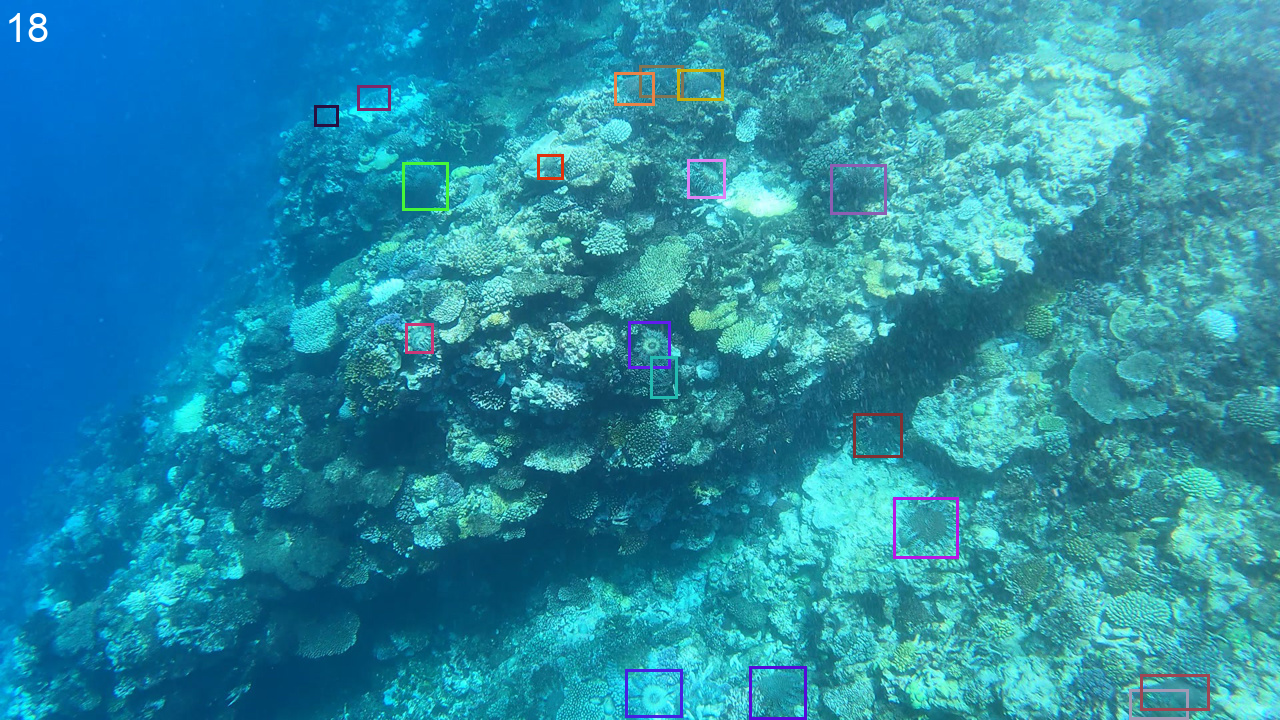

In [273]:
image = df.filepath[idx]
path = os.path.join('train_images', image)
plot_img(train_data_df, 1419)

# HOG + SVM

In [276]:
from skimage.feature import hog
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [389]:
windowSize = (32,32)
step = 6

train_images/video_1/9067.jpg
(720, 1280, 3)


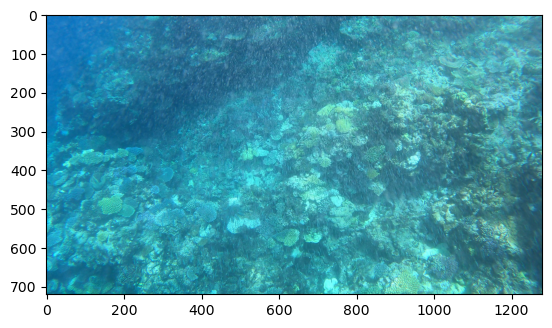

2


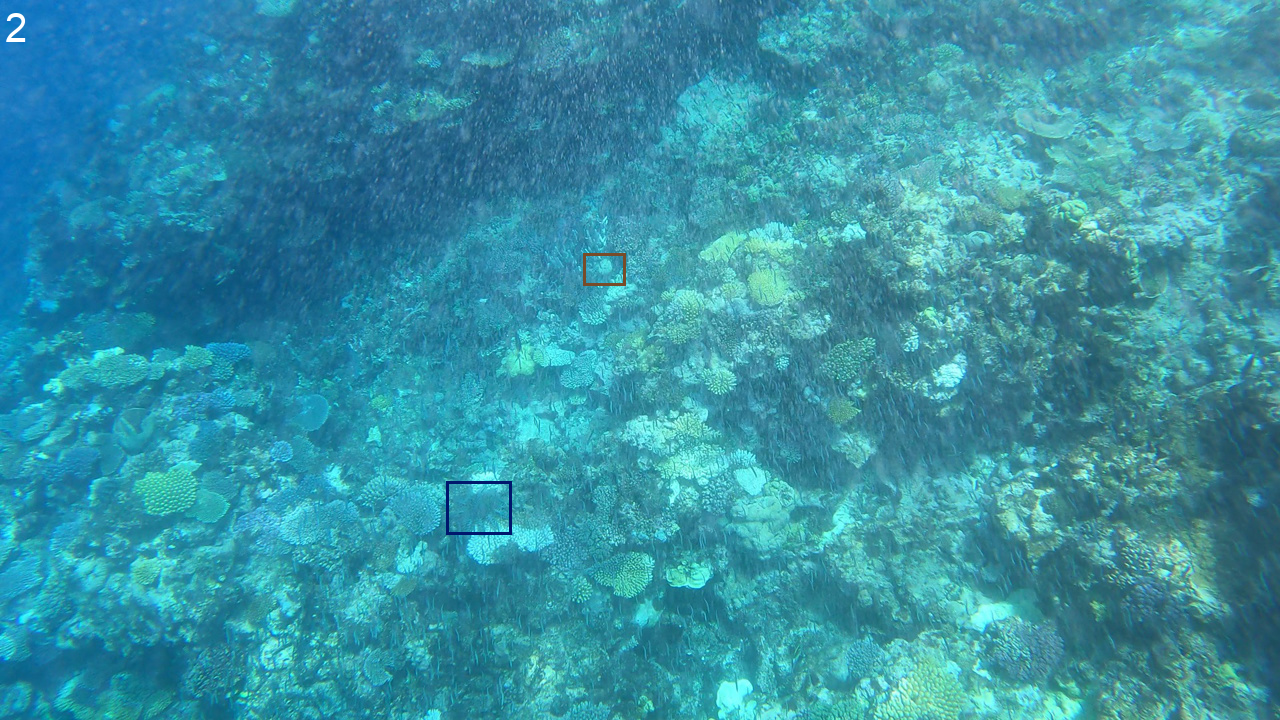

In [386]:
idx = 2

image = train_data_df.filepath[idx]
path = os.path.join(input_dir, image)
print(path)
img = cv2.imread(path)
X, Y, _ = img.shape
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

boxes = train_data_df.annotations[idx]
print(len(boxes))
pos_imgs = []
for box in boxes:
    roi = img[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']]
    pos_imgs.append(roi)

plot_img(path, boxes)

(32, 42, 3)


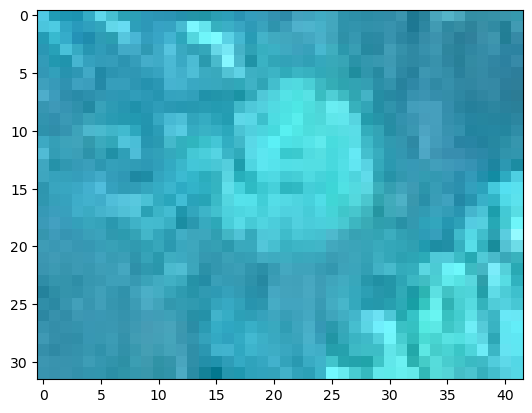

In [296]:
plt.imshow(pos_imgs[0])
print(pos_imgs[0].shape)

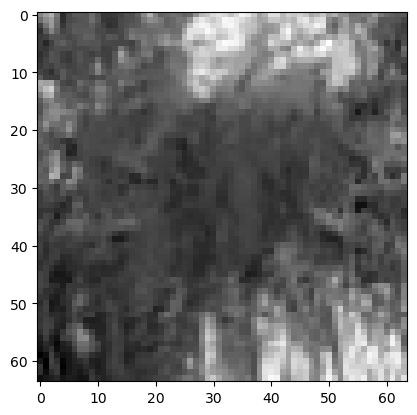

In [76]:
img_resized = cv2.resize(pos_imgs[0], (32, 32))
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, 'gray')

(7, 7, 2, 2, 9)


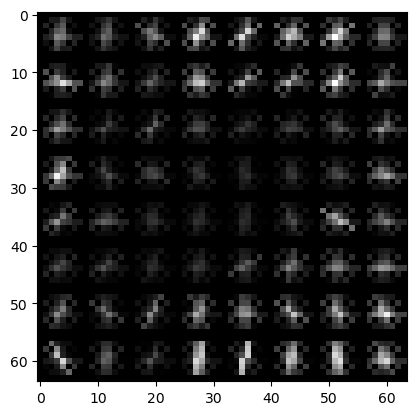

In [150]:
features, img_hog = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2,2), visualize=True, feature_vector=False)
print(features.shape)
plt.imshow(img_hog, 'gray')

In [303]:
def get_hog_features(image, windowSize):
    img_resized = cv2.resize(image, windowSize)
    img_gray = cv2.cvtColor(img_resized,cv2.COLOR_RGB2GRAY)
    features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), 
                  cells_per_block=(2,2), visualize=False, feature_vector=True)
    return features

def extract_features(image, boxes):
    features = []
    for box in boxes:
        roi = img[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']]
        hog_features = get_hog_features(roi, windowSize)
        features.append(hog_features)
    return features

In [306]:
pos_images = []
neg_images = []
pos_labels = np.ones(np.sum(pos_data_df.annotations.str.len()))
neg_labels = np.zeros(len(neg_data_df))

for i in range(len(pos_data_df)):
    path = pos_data_df.filepath[i]
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    bboxes = pos_data_df.annotations[i]
    pos_images += extract_features(img, bboxes)

for j in range(len(neg_data_df)):
    path = neg_data_df.filepath[j]
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    bboxes = neg_data_df.annotations[i]
    neg_images += extract_features(img, bboxes)
    
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [307]:
svc = SVC()
svc.fit(x_train,y_train)

y_pred = svc.predict(x_test)
fbeta_score(y_test, y_pred, beta=2.0)

0.9150848311775575

In [297]:
def sliding_window(image, windowSize, step):
    boxes = []
    rows, cols = image.shape[:2]
    (w_width, w_height) = windowSize
    for x in range(0, cols - w_width , step):
        for y in range(0, rows - w_height, step):
            boxes.append({'x': x, 'y':y, 'width':w_width, 'height':w_height})
    return boxes
    

In [379]:
def init_heatmap(image):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float64)
    return heatmap

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box['y']:box['y']+box['height'], box['x']:box['x']+box['width']] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap_norm = (heatmap - heatmap.min())/ (heatmap.max() - heatmap.min())
    plt.imshow(np.asarray(heatmap_norm * 255).astype(np.uint8), "gray")
    plt.show()
    heatmap_norm[heatmap_norm < threshold] = 0
    heatmap_scaled = np.asarray(heatmap_norm * 255).astype(np.uint8)
    plt.imshow(heatmap_scaled, "gray")
    plt.show()
    return heatmap_scaled

In [390]:
windows = sliding_window(img, windowSize, step)
windows_features = extract_features(img, windows)
result = svc.predict(windows_features)

bbox_list = []
for i in range(len(windows)):
    if result[i] == 1:
        bbox_list.append(windows[i])
        

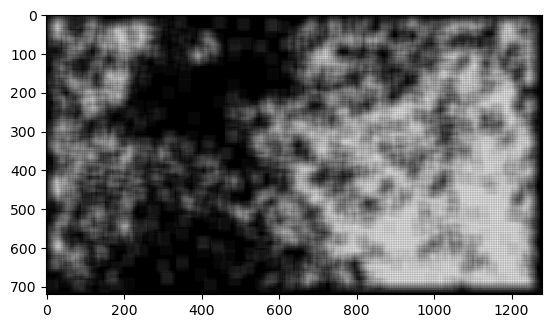

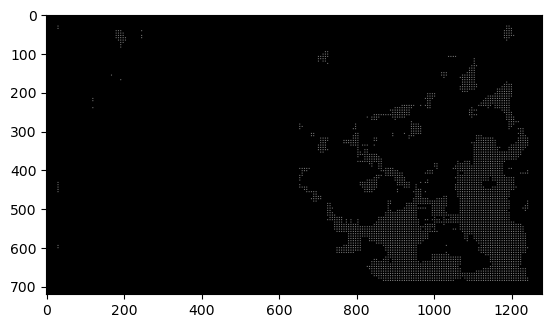

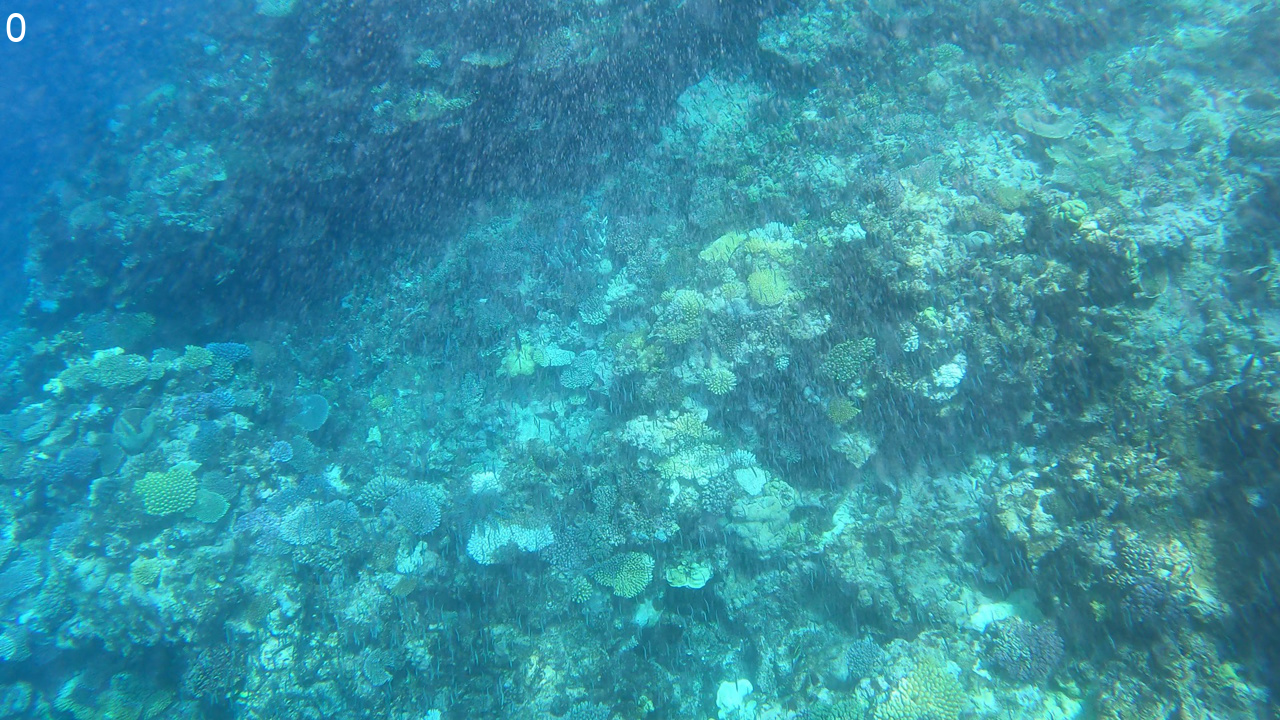

In [394]:
threshold = 0.80

heatmap = init_heatmap(img)
heatmap = add_heat(heatmap, bbox_list)
heatmap = apply_threshold(heatmap, threshold)

cnts, _ = cv2.findContours(heatmap, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bboxes = []
for c in cnts:

    if cv2.contourArea(c) < windowSize[0] * windowSize[1]:
            continue
    (x,y,w,h) = cv2.boundingRect(c)
    bboxes.append({'x': x, 'y':y, 'width':w, 'height':h})
plot_img(path, bboxes)